In [1]:
from gensim.models import KeyedVectors
word2vec_model = KeyedVectors.load(r"../word2vec-google-news-300.model")
print(len(word2vec_model))
# print(word2vec_model.key_to_index["a"])

3000000


In [2]:

import numpy as np
import json
# this code is taken from online and slightly modified

with open(r"../vocab.json") as f:
    dict = json.load(f)
    word_set = set(dict.keys())
vocab = set(word2vec_model.key_to_index.keys())

def charMapping(word_set):
    final_word_set = set()
    charMap = {}
    for word in vocab:
        if word in word_set:
            charMap[word] = word
            final_word_set.add(word)
        elif word.lower() in word_set:
            charMap[word.lower()] = word
            final_word_set.add(word.lower())
    word_set = final_word_set
    return charMap

def augment_wordset_with_OOV(word_set):
    with open(r"../oovMap.json") as f:
        dict = json.load(f)
        # print(dict)
        for key in dict:
            words = dict[key]
            for word in words:
                word_set.add(word)
            if key in word_set:
                word_set.remove(key)

def restrict_w2v(w2v, restricted_word_set, handle_oov = False):
    if handle_oov:
        augment_wordset_with_OOV(restricted_word_set)
        charMap = charMapping(restricted_word_set)
    
    new_key_to_index = {} #given word, give index
    new_index_to_key = {} #given index, give word
    new_vectors = []
    
    new_key_to_index["</s>"] = 0
    new_index_to_key[0] = "</s>"
    new_vectors.append([0] * 300)
    
    for word in restricted_word_set:
        if word not in charMap:
            continue
        index = w2v.key_to_index[charMap[word]]
        vec = w2v.vectors[index]
        val = len(new_key_to_index)
        new_key_to_index[word] = val
        new_index_to_key[val] = word
        new_vectors.append(vec)
  
    w2v.key_to_index = new_key_to_index
    w2v.index_to_key = new_index_to_key
    w2v.vectors = new_vectors

restrict_w2v(word2vec_model, word_set, handle_oov=True)
print(len(word2vec_model.vectors))
# print(word2vec_model.key_to_index["a"])

15583


In [3]:
import torch.nn as nn
import torch

class SentimentGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout=0.2, bidirectional=True):
        super(SentimentGRU, self).__init__()
        self.embed_layer = nn.Embedding.from_pretrained(torch.FloatTensor(word2vec_model.vectors), freeze=False, padding_idx=0)
        self.activation = nn.ReLU()
        
        # Initialize the GRU layer
        self.gru = nn.GRU(
            input_size,
            hidden_size,
            num_layers=num_layers,
            bias=True,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,  # Dropout is only applied if num_layers > 1
            bidirectional=bidirectional
        )
        
        # Fully connected layer
        gru_output_size = hidden_size * 2 if bidirectional else hidden_size
        self.fc = nn.Linear(gru_output_size, output_size)

    def forward(self, x, mask):
        x = self.embed_layer(x)
        x = self.activation(x)
        
        # Compute the mask for the padded sequences
        mask = (x.sum(dim=2) != 0).float()
        lengths = mask.sum(dim=1).int()
        
        # Pack the padded sequence
        packed_x = nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        
        # Pass through the GRU
        packed_out, hidden = self.gru(packed_x)
        
        # Unpack the sequence
        out, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)
        
        # Apply mean pooling over valid parts only
        out = (out * mask.unsqueeze(2)).sum(dim=1) / mask.sum(dim=1, keepdim=True)
        
        # Fully connected layer
        out = self.fc(out)
        
        return out


In [4]:
with open(r"../oovMap.json") as f:
    oovMap = json.load(f)

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import numpy as np

class SentimentDataset(Dataset):
    def __init__(self, dataset, word2vec_model, max_length=100):
        self.dataset = dataset
        self.word2vec = word2vec_model
        self.max_length = max_length  # Maximum sequence length for padding

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Get text and label
        text = self.dataset[idx]['text']
        label = self.dataset[idx]['label']
        
        # Convert text to embeddings
        tokens = text # Assuming text is tokenized already
        # embeddings = [self.word2vec[word] for word in tokens if word in self.word2vec]
        # embeddings = [self.word2vec.key_to_index.get(word) for word in tokens if word in self.word2vec]
        embeddings = []
        # print(tokens)
        for word in tokens:
            # print("word: ", word)
            if word in self.word2vec:
                embeddings.append(self.word2vec.key_to_index.get(word))
                continue
            if word not in oovMap:
                continue
            for chunk in oovMap[word]:
                # print("chunk:" , chunk)
                embeddings.append(self.word2vec.key_to_index.get(chunk))            
        
        # Truncate sequences - will pad later
        if len(embeddings) > self.max_length:
            embeddings = embeddings[:self.max_length]
        
        if len(embeddings) == 0:
            return self.__getitem__((idx + 1) % len(self.dataset))  # Skip empty sequences
        
        embeddings = np.array(embeddings)
        
        return torch.tensor(embeddings, dtype=torch.int32), torch.tensor(label, dtype=torch.float32)

def collate_fn(batch):
    '''Creates mini-batch tensors from the list of tuples (embeddings, labels, mask).'''
    
    # embedding_dim = batch[0][0].size(1)
    
    # Separate embeddings and labels
    embeddings = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    
    # print(len(batch))     
    # print(embeddings)
    # Stack them into tensors
    embeddings = pad_sequence(embeddings, batch_first=True) # (B, L, D)
    # print(len(batch))     
    # print([len(embeddings[i]) for i in range(len(embeddings))])
    # Create the mask
    mask = (embeddings != 0).float() # (B, L) - 1 if there is a word, 0 if it's a padding
    
    labels = torch.stack(labels)
    
    return embeddings, labels, mask


In [6]:
from datasets import load_from_disk
import gensim.downloader as api
from gensim.models import KeyedVectors

# This is the training dataset
path_to_train_set = r"../tokenised_datasets/tokenised_train_dataset"
train_dataset = load_from_disk(path_to_train_set)
train_data = SentimentDataset(train_dataset, word2vec_model)
train_loader = DataLoader(train_data, batch_size=48, shuffle=True, collate_fn=collate_fn)

# Get the same for test and validation
path_to_test_set = r"../tokenised_datasets/tokenised_test_dataset"
test_dataset = load_from_disk(path_to_test_set)
test_data = SentimentDataset(test_dataset, word2vec_model)
test_loader = DataLoader(test_data, batch_size=48, shuffle=False, collate_fn=collate_fn)

path_to_val_set = r"../tokenised_datasets/tokenised_validation_dataset"
val_dataset = load_from_disk(path_to_val_set)
val_data = SentimentDataset(val_dataset, word2vec_model)
val_loader = DataLoader(val_data, batch_size=48, shuffle=False, collate_fn=collate_fn)


c:\Users\ranlo\Downloads\SC4002_NLP_Project\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
# Define model parameters
input_size = word2vec_model.vector_size         # Dimension of Word2Vec embeddings
hidden_size = 16        # Number of hidden units
output_size = 1          # Output size (1 for binary classification)
num_layers = 2           # Number of stacked RNN layers
dropout = 0.60        # Dropout rate for regularization


In [14]:
def validate_model(model, val_loader, device, criterion, val_losses=[], val_accuracies=[]):
    # Validation Phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_correct_predictions = 0
    val_total_samples = 0

    with torch.no_grad():  # Disable gradient tracking for validation
        for val_embeddings, val_labels, mask in val_loader:
            val_embeddings, val_labels, mask = val_embeddings.to(device), val_labels.to(device), mask.to(device)
            val_outputs = model(val_embeddings, mask).squeeze()
            loss = criterion(val_outputs, val_labels)
            
            val_loss += loss.item() * val_labels.size(0)  # Multiply by batch size for total loss
            val_predictions = (torch.sigmoid(val_outputs) >= 0.5).float()  # Threshold at 0.5
            val_correct_predictions += (val_predictions == val_labels).sum().item()
            val_total_samples += val_labels.size(0)

    # Calculate average validation loss and accuracy
    avg_val_loss = val_loss / val_total_samples
    val_accuracy = val_correct_predictions / val_total_samples
    
    # Store validation metrics for plotting
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    
    # print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    

Epoch 1/100, Loss: 0.6919, Accuracy: 0.5257 Validation Accuracy: 0.5553
Epoch 2/100, Loss: 0.6894, Accuracy: 0.5674 Validation Accuracy: 0.6191
Epoch 3/100, Loss: 0.6866, Accuracy: 0.5934 Validation Accuracy: 0.6248
Epoch 4/100, Loss: 0.6826, Accuracy: 0.6321 Validation Accuracy: 0.6595
Epoch 5/100, Loss: 0.6754, Accuracy: 0.6614 Validation Accuracy: 0.6548
Epoch 6/100, Loss: 0.6639, Accuracy: 0.6808 Validation Accuracy: 0.6614
Epoch 7/100, Loss: 0.6406, Accuracy: 0.7041 Validation Accuracy: 0.6764
Epoch 8/100, Loss: 0.6010, Accuracy: 0.7261 Validation Accuracy: 0.6764
Epoch 9/100, Loss: 0.5405, Accuracy: 0.7477 Validation Accuracy: 0.6923
Epoch 10/100, Loss: 0.4731, Accuracy: 0.7882 Validation Accuracy: 0.7045
Epoch 11/100, Loss: 0.4145, Accuracy: 0.8231 Validation Accuracy: 0.7139
Epoch 12/100, Loss: 0.3686, Accuracy: 0.8474 Validation Accuracy: 0.7251
Epoch 13/100, Loss: 0.3323, Accuracy: 0.8726 Validation Accuracy: 0.7261
Epoch 14/100, Loss: 0.2996, Accuracy: 0.8877 Validation Accu

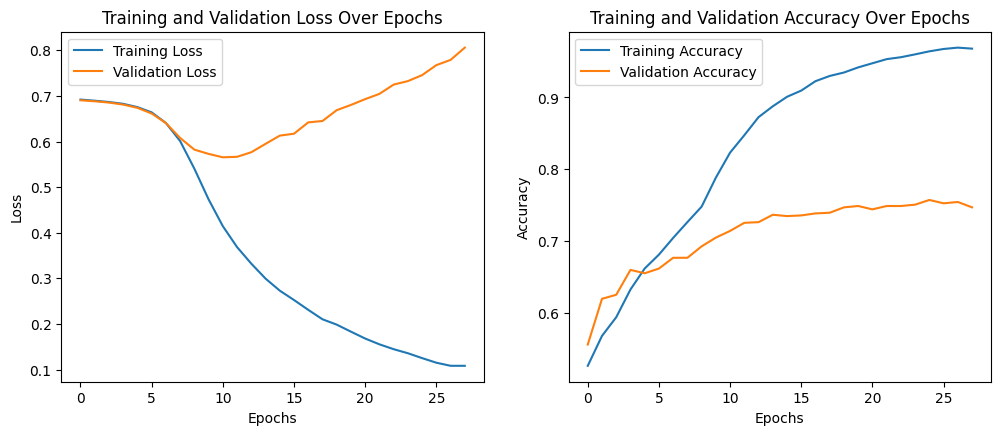

In [15]:
import matplotlib.pyplot as plt
import torch.optim as optim

# Binary Cross-Entropy Loss with Logits
criterion = nn.BCEWithLogitsLoss()

# Define the optimizer with the model's parameters and a learning rate
learning_rate = 0.00005

# Check if CUDA is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
model = SentimentGRU(input_size, hidden_size, output_size, num_layers, dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)


# Training parameters
num_epochs = 100
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    # Set the model to training mode
    model.train()
    for embeddings, labels, mask in train_loader:
        # Move data to the same device as model (GPU if available)
        embeddings, labels, mask = embeddings.to(device), labels.to(device), mask.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(embeddings, mask).squeeze()

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print the gradients
        # for name, param in model.named_parameters():
        #     print(name, param.grad)
        
        # Accumulate the loss and accuracy
        epoch_loss += loss.item() * labels.size(0)  # Multiply by batch size for total loss
        predictions = (torch.sigmoid(outputs) >= 0.5).float()  # Threshold at 0.5
        correct_predictions += (predictions == labels).sum().item()
        total_samples += labels.size(0)

    # Calculate average loss and accuracy for the epoch
    avg_loss = epoch_loss / total_samples
    accuracy = correct_predictions / total_samples
    
    # Store metrics for plotting
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}", end=" ")
    validate_model(
        model,
        val_loader,
        device,
        criterion,
        val_losses,
        val_accuracies
    )
    # Early stopping: if the moving average validation accuracy has decreased, then stop
    if epoch > 10 and val_accuracies[-1] < np.mean(val_accuracies[-10:-1]):
        print("Early stopping")
        break 

# Plot the training and validation loss and accuracy over epochs
plt.figure(figsize=(12, 10))

# Plot Loss
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()

# Plot Training Accuracy
plt.subplot(2, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy Over Epochs")
plt.legend()

plt.show()


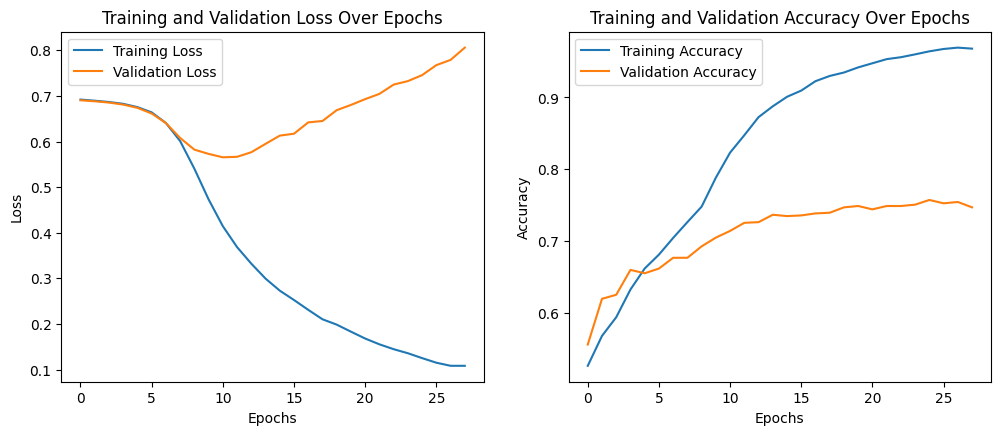

In [16]:
# Plot the training and validation loss and accuracy over epochs
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))

# Plot Loss
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()

# Plot Training Accuracy
plt.subplot(2, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy Over Epochs")
plt.legend()

plt.show()


In [17]:
# import torch
# # Save the model
torch.save(model.state_dict(), 'sentiment_gru_2hl_{}_{}_with_OOV.pth'.format(hidden_size, str(learning_rate)[2:]))

#load the model
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = SentimentRNN(input_size, hidden_size, output_size, num_layers, dropout).to(device)
# model.load_state_dict(torch.load('sentiment_rnn_1hl_16_00005_with_OOV.pth'))


In [18]:
from datasets import load_from_disk
from gensim.models import KeyedVectors


# Check if CUDA is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print('reach')
# This is the word2vec model
# word2vec_model = KeyedVectors.load(r"../word2vec-google-news-300.model")

# Set the model to evaluation mode
model.eval()

test_predictions = []
test_targets = []

# print(len(test_loader))
for i, x in enumerate(test_loader):
    # print(i, end = " ")
    embeddings, labels, mask = x
    # Move data to the same device as model
    embeddings, labels, mask = embeddings.to(device), labels.to(device), mask.to(device)
    
    # Forward pass
    outputs = model(embeddings, mask).squeeze()
    
    # Store the actual and predicted labels
    predictions = (torch.sigmoid(outputs) >= 0.5).float()
    test_predictions.extend(predictions.tolist())
    test_targets.extend(labels.tolist())
    
# Calculate the test accuracy
test_predictions = np.array(test_predictions)
test_targets = np.array(test_targets)
test_accuracy = np.mean(test_predictions == test_targets)

print(f"testing accuracy: {test_accuracy:.4f}")

testing accuracy: 0.7636
